In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import shapiro, skew, uniform, triang, laplace, logistic, kstest
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.svm import SVR
from itertools import product

# Define the path to the Excel file
excel_file_path = r'C:\Users\rafae\Capstone Fall 2024\all_merged_data_imputed_hearbeat_avg.xlsx'

# Function to load data from Excel file
def load_data_from_excel(file_path):
    """
    Load data from an Excel file.

    Parameters:
    file_path (str): Path to the Excel file.

    Returns:
    DataFrame: The DataFrame containing the data.
    """
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    return pd.read_excel(file_path)  # Load the first sheet by default

# Load the data
data = load_data_from_excel(excel_file_path)

# Remove specified columns
columns_to_remove = [
    'Activity_Record_Missing',
    'Sleep_Record_Missing',
    'Heartbeat_Record_Missing',
    'Met_Record_Missing',
    'met_Record_Missing'
]

data.drop(columns=columns_to_remove, inplace=True, errors='ignore')

print("Columns removed. Data loaded and cleaned correctly.")

# Check the first few rows of the cleaned DataFrame
print(data.head())


Columns removed. Data loaded and cleaned correctly.
           Id ActivityDate  TotalSteps  TotalDistance  TrackerDistance  \
0  1503960366   2016-04-12     13162.0           8.50             8.50   
1  1503960366   2016-04-13     10735.0           6.97             6.97   
2  1503960366   2016-04-14     10460.0           6.74             6.74   
3  1503960366   2016-04-15      9762.0           6.28             6.28   
4  1503960366   2016-04-16     12669.0           8.16             8.16   

   VeryActiveDistance  ModeratelyActiveDistance  LightActiveDistance  \
0                1.88                      0.55                 6.06   
1                1.57                      0.69                 4.71   
2                2.44                      0.40                 3.91   
3                2.14                      1.26                 2.83   
4                2.71                      0.41                 5.04   

   VeryActiveMinutes  FairlyActiveMinutes  ...  Calories  Heartbeat_Ma

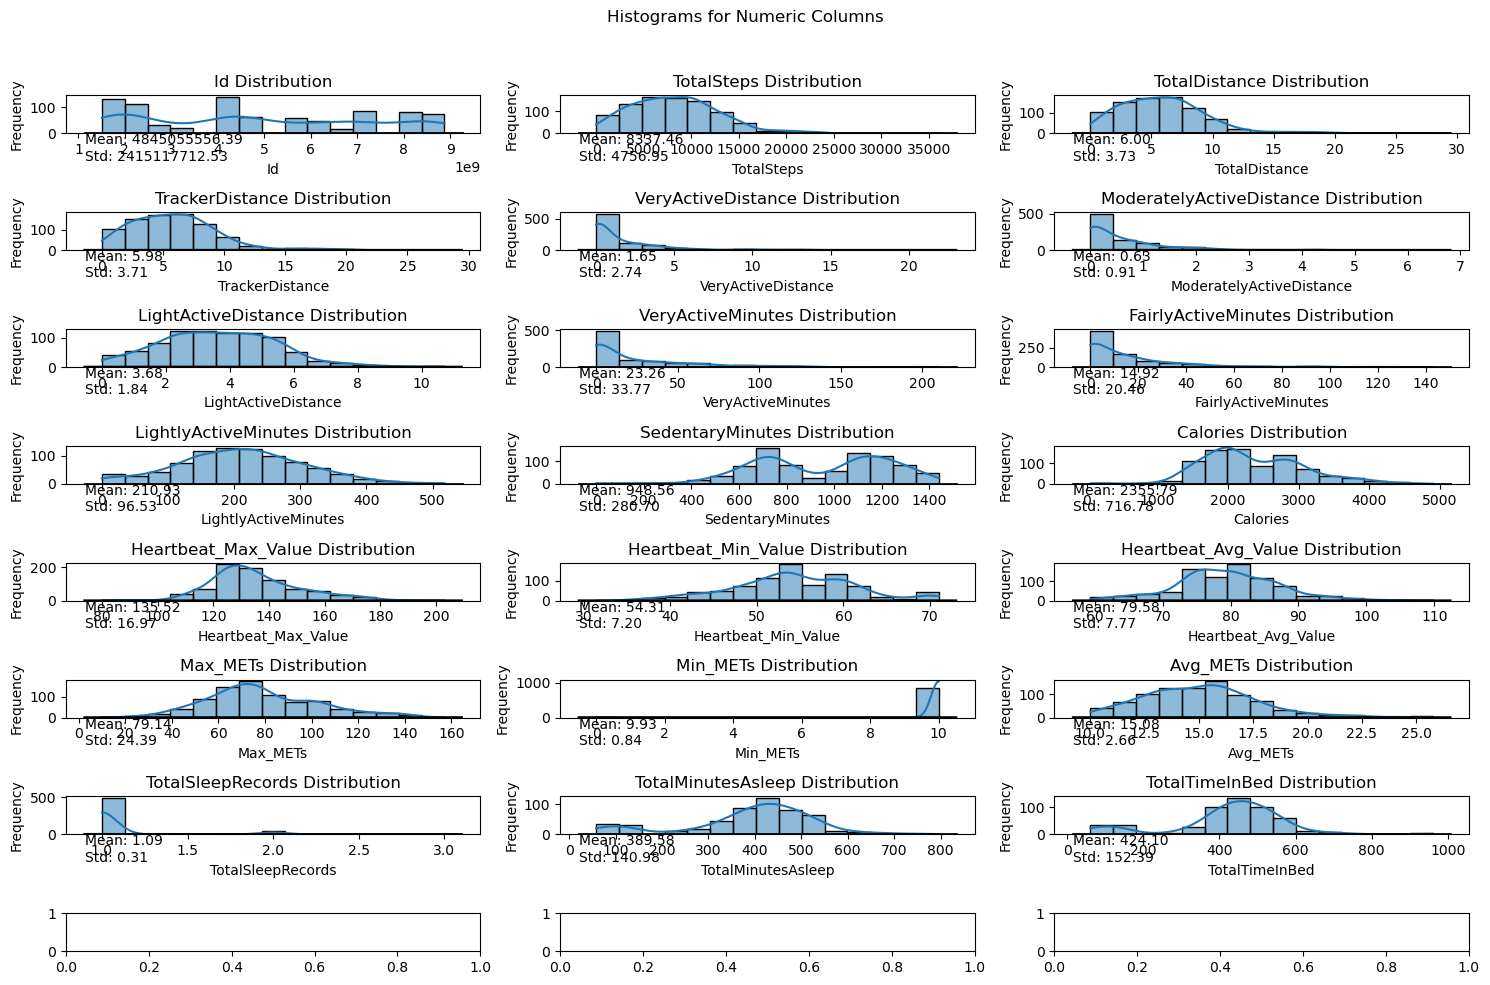

In [ ]:
# Function to plot histograms for a list of columns
def plot_histograms(data):
    columns = data.select_dtypes(include=[np.number]).columns  # Select numeric columns
    num_columns = len(columns)

    fig, axes = plt.subplots(nrows=(num_columns // 3) + 1, ncols=3, figsize=(15, 10))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.histplot(data[col], bins=15, kde=True, ax=axes[i], edgecolor='black')
        axes[i].set_title(f'{col} Distribution')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

        # Fit a normal distribution and plot the PDF
        mu, std = stats.norm.fit(data[col].dropna())
        xmin, xmax = axes[i].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mu, std)
        axes[i].plot(x, p, 'k', linewidth=2)
        axes[i].text(xmin, max(p), f'Mean: {mu:.2f}\nStd: {std:.2f}', fontsize=10, verticalalignment='top')

    plt.suptitle('Histograms for Numeric Columns')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot histograms for all numeric columns in the DataFrame
plot_histograms(data)


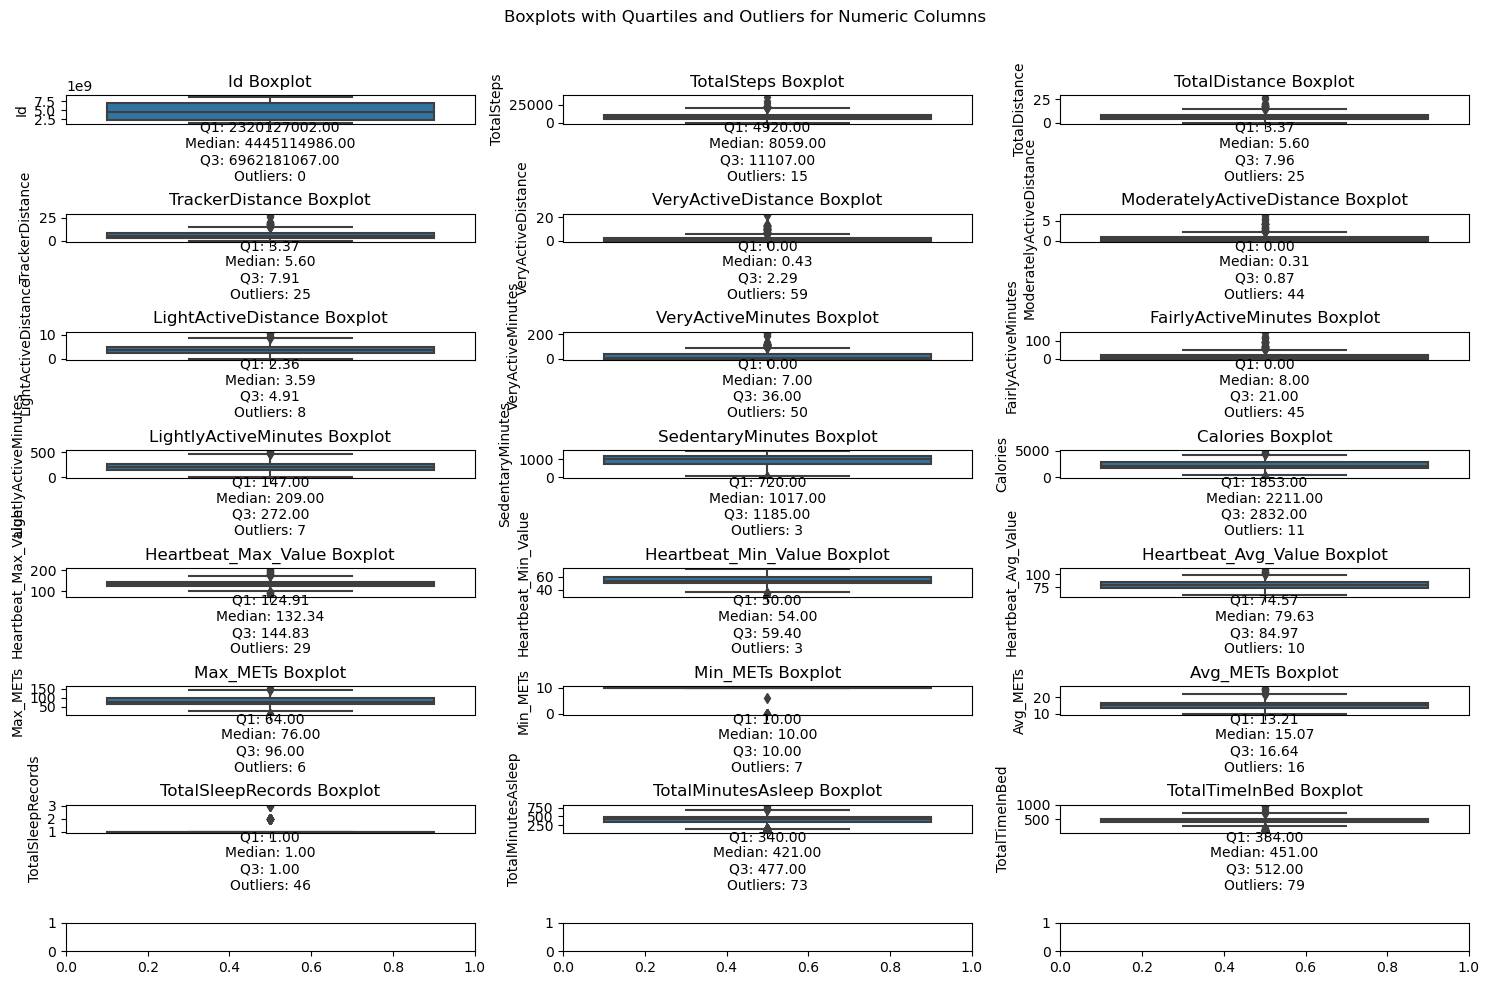

In [ ]:
# Function to plot boxplots for all numeric columns with quartile values and outliers
def plot_boxplots_with_quartiles_and_outliers(data):
    numeric_columns = data.select_dtypes(include=[np.number]).columns  # Select numeric columns
    num_columns = len(numeric_columns)

    fig, axes = plt.subplots(nrows=(num_columns // 3) + 1, ncols=3, figsize=(15, 10))
    axes = axes.flatten()

    for i, col in enumerate(numeric_columns):
        sns.boxplot(y=data[col], ax=axes[i])
        axes[i].set_title(f'{col} Boxplot')
        axes[i].set_ylabel(col)

        # Calculate quartiles
        Q1 = data[col].quantile(0.25)
        Q2 = data[col].quantile(0.50)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1

        # Calculate outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col]

        # Display quartile values and outliers
        axes[i].text(0.5, 0.1, f'Q1: {Q1:.2f}\nMedian: {Q2:.2f}\nQ3: {Q3:.2f}\nOutliers: {len(outliers)}',
                     transform=axes[i].transAxes, fontsize=10, verticalalignment='top', horizontalalignment='center')

    plt.suptitle('Boxplots with Quartiles and Outliers for Numeric Columns')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot boxplots with quartiles and outliers for all numeric columns in the DataFrame
plot_boxplots_with_quartiles_and_outliers(data)


In [ ]:
# Inspect data
print("Original DataFrame info:")
print(data.info())
print("First few rows of the DataFrame:")
print(data.head())

# Remove irrelevant columns
data_cleaned = data.drop(columns=['Id', 'ActivityDate'], errors='ignore')

# Handle missing values
data_cleaned = data_cleaned.dropna(subset=['TotalSleepRecords', 'TotalMinutesAsleep', 'TotalTimeInBed'])

# Max normalization function
def max_normalization(df):
    return df / df.max()

numeric_cols = data_cleaned.select_dtypes(include=[np.number]).columns
data_cleaned[numeric_cols] = max_normalization(data_cleaned[numeric_cols])

# Split data into features and target
X = data_cleaned.drop(columns=['TotalSleepRecords', 'TotalMinutesAsleep', 'TotalTimeInBed'])
y = data_cleaned[['TotalSleepRecords', 'TotalMinutesAsleep', 'TotalTimeInBed']]

# Display cleaned data info
print("Cleaned DataFrame info:")
print(data_cleaned.info())
print("First few rows of the cleaned DataFrame:")
print(data_cleaned.head())


Original DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861 entries, 0 to 860
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Id                        861 non-null    int64         
 1   ActivityDate              861 non-null    datetime64[ns]
 2   TotalSteps                861 non-null    float64       
 3   TotalDistance             861 non-null    float64       
 4   TrackerDistance           861 non-null    float64       
 5   VeryActiveDistance        861 non-null    float64       
 6   ModeratelyActiveDistance  861 non-null    float64       
 7   LightActiveDistance       861 non-null    float64       
 8   VeryActiveMinutes         861 non-null    int64         
 9   FairlyActiveMinutes       861 non-null    int64         
 10  LightlyActiveMinutes      861 non-null    int64         
 11  SedentaryMinutes          861 non-null    int64         
 1

In [ ]:
# Calculate correlation coefficients for all numeric columns
correlation_matrix = data_cleaned.corr()

# Get the correlation of all features with the target columns
correlation_with_target = correlation_matrix[y.columns]

# Drop the target columns from the correlation table to only show correlations of other features
correlation_with_target = correlation_with_target.drop(index=y.columns, errors='ignore')

# Display the correlation table for all features against the target columns
print("Correlation of Features with Target Columns:")
print(correlation_with_target)

Correlation of Features with Target Columns:
                          TotalSleepRecords  TotalMinutesAsleep  \
TotalSteps                        -0.123549           -0.203444   
TotalDistance                     -0.108514           -0.182445   
TrackerDistance                   -0.107220           -0.168510   
VeryActiveDistance                -0.078964           -0.111453   
ModeratelyActiveDistance          -0.052336           -0.164447   
LightActiveDistance               -0.070104           -0.113575   
VeryActiveMinutes                 -0.097125           -0.060420   
FairlyActiveMinutes               -0.064517           -0.143604   
LightlyActiveMinutes              -0.048190           -0.127523   
SedentaryMinutes                  -0.134433           -0.477487   
Calories                          -0.032607            0.000292   
Heartbeat_Max_Value               -0.097849           -0.132245   
Heartbeat_Min_Value               -0.073658           -0.187559   
Heartbeat_Avg_Val

# Splits and seeds function

In [ ]:
def split_data(X, y, seeds):
    splits = []
    for seed in seeds:
        np.random.seed(seed)
        # Split into train, validation, and test
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)
        # Add seed to each split tuple
        splits.append((X_train, X_val, X_test, y_train, y_val, y_test, seed))
    return splits

# Define your seeds
seeds = [42, 100, 200, 300, 400]

# Call the split_data function to get the splits
splits = split_data(X, y, seeds)

print("Data splitting completed successfully for the given seeds.")



Data splitting completed successfully for the given seeds.


In [ ]:
# Store results for different seeds
results_XGB = []
best_params = {}

# Define hyperparameters for XGBoost (at least 3 parameters)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Loop through each combination of hyperparameters
for params in product(*param_grid.values()):
    param_dict = dict(zip(param_grid.keys(), params))

    # Convert the param_dict to a string (or tuple) to avoid the "unhashable type" error
    param_str = str(param_dict)  # Convert to string

    # Loop through each fixed seed and corresponding split (now including seed in each tuple)
    for (X_train, X_val, X_test, y_train, y_val, y_test, seed) in splits:  # Unpack seed from splits
        # Loop through each target column (assuming y_train has multiple target columns)
        for target in y_train.columns:
            # Initialize the model with the current parameters
            model = XGBRegressor(**param_dict)  # Pass parameters dynamically

            # Train the model
            model.fit(X_train, y_train[target])

            # Make predictions
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            test_preds = model.predict(X_test)

            # Calculate errors
            train_error = np.sqrt(mean_squared_error(y_train[target], train_preds))
            val_error = np.sqrt(mean_squared_error(y_val[target], val_preds))
            test_error = np.sqrt(mean_squared_error(y_test[target], test_preds))

            # Store the results for the current parameters, target, and seed
            results_XGB.append({
                'params': param_str,  # Store the parameter string (not the dictionary)
                'target': target,      # Add the target column name
                'train_error': train_error,
                'val_error': val_error,
                'test_error': test_error,
                'seed': seed           # Add the seed value
            })

# Convert results to DataFrame for easier analysis
results_XGB = pd.DataFrame(results_XGB)

# Find the average errors for each target and each combination of parameters
average_errors_XGB = results_XGB.groupby(['target', 'params']).agg({
    'train_error': 'mean',
    'val_error': 'mean',
    'test_error': 'mean'
}).reset_index()

# Rename columns for clarity
average_errors_XGB.columns = ['target', 'params', 'average_train_error', 'average_val_error', 'average_test_error']

# Display the results
print("Data splitting and model evaluation completed successfully.")
print("\nAll Results DataFrame:")
print(results_XGB)

print("\nAverage Errors per Target and Params:")
print(average_errors_XGB)

# Find the combination of parameters with the lowest average_val_error for each target
best_params_per_target_XGB = average_errors_XGB.loc[
    average_errors_XGB.groupby('target')['average_val_error'].idxmin()
].reset_index(drop=True)

print("\nBest combination of parameters with the lowest average_val_error for each target:")
print(best_params_per_target_XGB)


Data splitting and model evaluation completed successfully.

All Results DataFrame:
                                                 params              target  \
0     {'n_estimators': 100, 'max_depth': 3, 'learnin...   TotalSleepRecords   
1     {'n_estimators': 100, 'max_depth': 3, 'learnin...  TotalMinutesAsleep   
2     {'n_estimators': 100, 'max_depth': 3, 'learnin...      TotalTimeInBed   
3     {'n_estimators': 100, 'max_depth': 3, 'learnin...   TotalSleepRecords   
4     {'n_estimators': 100, 'max_depth': 3, 'learnin...  TotalMinutesAsleep   
...                                                 ...                 ...   
3640  {'n_estimators': 300, 'max_depth': 7, 'learnin...  TotalMinutesAsleep   
3641  {'n_estimators': 300, 'max_depth': 7, 'learnin...      TotalTimeInBed   
3642  {'n_estimators': 300, 'max_depth': 7, 'learnin...   TotalSleepRecords   
3643  {'n_estimators': 300, 'max_depth': 7, 'learnin...  TotalMinutesAsleep   
3644  {'n_estimators': 300, 'max_depth': 7, 'le

In [ ]:
# Define hyperparameters for SVR (at least 3 parameters)
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'epsilon': [0.01, 0.1, 0.2],  # Epsilon in the epsilon-SVR model
    'kernel': ['linear', 'rbf', 'poly'],  # Type of kernel to use
}

# Store results for different seeds
results_SVR = []

# Initialize dictionaries to track best parameters for each target
best_params = {}  # Will store best params for each target
best_val_error = {}  # Will store best validation error for each target

# Initialize best validation errors for each target as infinity
for target in y_train.columns:
    best_val_error[target] = float('inf')
    best_params[target] = None

# Generate combinations of parameters
for params in product(*param_grid.values()):
    param_dict = dict(zip(param_grid.keys(), params))

    # Convert the param_dict to a string (to make it hashable)
    param_str = str(param_dict)  # Convert dictionary to string

    # Loop through each fixed seed and corresponding split
    for (X_train, X_val, X_test, y_train, y_val, y_test, seed) in splits:
        # Loop through each target column (assuming y_train has multiple target columns)
        for target in y_train.columns:
            # Initialize the model with the current parameters
            model = SVR(**param_dict)  # Pass parameters dynamically to SVR

            # Train the model
            model.fit(X_train, y_train[target])

            # Make predictions
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            test_preds = model.predict(X_test)

            # Calculate errors
            train_error = np.sqrt(mean_squared_error(y_train[target], train_preds))
            val_error = np.sqrt(mean_squared_error(y_val[target], val_preds))
            test_error = np.sqrt(mean_squared_error(y_test[target], test_preds))

            # Store the results for the current parameters, target, and seed
            results_SVR.append({
                'params': param_str,  # Store the parameter string (not the dictionary)
                'target': target,
                'train_error': train_error,
                'val_error': val_error,
                'test_error': test_error,
                'seed': seed  # Store the seed value
            })

# Convert results to DataFrame for easier analysis
results_SVR = pd.DataFrame(results_SVR)

# Find the average errors for each target and each combination of parameters (not by seed)
average_errors_SVR = results_SVR.groupby(['target', 'params']).agg({
    'train_error': 'mean',
    'val_error': 'mean',
    'test_error': 'mean'
}).reset_index()

# Rename columns for clarity
average_errors_SVR.columns = ['target', 'params', 'average_train_error', 'average_val_error', 'average_test_error']

# Display the results
print("Data splitting and model evaluation completed successfully.")
print("\nAll Results DataFrame:")
print(results_SVR)

print("\nAverage Errors per Target and Params:")
print(average_errors_SVR)

# Find the combination of parameters with the lowest average_val_error for each target
best_params_per_target_SVR = average_errors_SVR.loc[
    average_errors_SVR.groupby('target')['average_val_error'].idxmin()
].reset_index(drop=True)

# Display the results
print("\nBest combination of parameters with the lowest average_val_error for each target:")
print(best_params_per_target_SVR)


Data splitting and model evaluation completed successfully.

All Results DataFrame:
                                              params              target  \
0    {'C': 0.1, 'epsilon': 0.01, 'kernel': 'linear'}   TotalSleepRecords   
1    {'C': 0.1, 'epsilon': 0.01, 'kernel': 'linear'}  TotalMinutesAsleep   
2    {'C': 0.1, 'epsilon': 0.01, 'kernel': 'linear'}      TotalTimeInBed   
3    {'C': 0.1, 'epsilon': 0.01, 'kernel': 'linear'}   TotalSleepRecords   
4    {'C': 0.1, 'epsilon': 0.01, 'kernel': 'linear'}  TotalMinutesAsleep   
..                                               ...                 ...   
400      {'C': 10, 'epsilon': 0.2, 'kernel': 'poly'}  TotalMinutesAsleep   
401      {'C': 10, 'epsilon': 0.2, 'kernel': 'poly'}      TotalTimeInBed   
402      {'C': 10, 'epsilon': 0.2, 'kernel': 'poly'}   TotalSleepRecords   
403      {'C': 10, 'epsilon': 0.2, 'kernel': 'poly'}  TotalMinutesAsleep   
404      {'C': 10, 'epsilon': 0.2, 'kernel': 'poly'}      TotalTimeInBed   

   

In [ ]:
# Define hyperparameters for KNN (filter parameters with at least 3 values)
param_grid = {
    'n_neighbors': [3, 5, 7, 10, 20],  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weight function for prediction
    'metric': ['minkowski', 'euclidean', 'manhattan'],  # Distance metric
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm to use for computation
    'leaf_size': [10, 20, 30],  # Controls speed of construction and query
}

# Store results for different seeds
results_KNN = []

# Initialize dictionaries to track the best parameters and validation errors for each target
best_params = {}  # Store best params for each target
best_val_error = {}  # Store best validation errors for each target

# Initialize the best validation errors for each target to infinity (we'll minimize this value)
for target in y_train.columns:
    best_val_error[target] = float('inf')
    best_params[target] = None

# Generate combinations of parameters
for params in product(*param_grid.values()):
    param_dict = dict(zip(param_grid.keys(), params))

    # Convert the param_dict to a string (to make it hashable)
    param_str = str(param_dict)  # Convert dictionary to string

    # Loop through each fixed seed and corresponding split
    for (X_train, X_val, X_test, y_train, y_val, y_test, seed) in splits:
        # Loop through each target column (assuming y_train has multiple target columns)
        for target in y_train.columns:
            # Initialize the model with the current parameters
            model = KNeighborsRegressor(**param_dict)  # Pass parameters dynamically to KNN

            # Train the model
            model.fit(X_train, y_train[target])

            # Make predictions
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            test_preds = model.predict(X_test)

            # Calculate errors
            train_error = np.sqrt(mean_squared_error(y_train[target], train_preds))
            val_error = np.sqrt(mean_squared_error(y_val[target], val_preds))
            test_error = np.sqrt(mean_squared_error(y_test[target], test_preds))

            # Store the results for the current parameters, target, and seed
            results_KNN.append({
                'params': param_str,  # Store the parameter string (not the dictionary)
                'target': target,
                'train_error': train_error,
                'val_error': val_error,
                'test_error': test_error,
                'seed': seed  # Store the seed value
            })

            # Update the best parameters for this target if we find a lower validation error
            if val_error < best_val_error[target]:
                best_val_error[target] = val_error
                best_params[target] = param_dict

# Convert results to DataFrame for easier analysis
results_KNN = pd.DataFrame(results_KNN)

# Find the average errors for each target and each combination of parameters (not by seed)
average_errors_KNN = results_KNN.groupby(['target', 'params']).agg({
    'train_error': 'mean',
    'val_error': 'mean',
    'test_error': 'mean'
}).reset_index()

# Rename columns for clarity
average_errors_KNN.columns = ['target', 'params', 'average_train_error', 'average_val_error', 'average_test_error']

# Display the results
print("Data splitting and model evaluation completed successfully.")
print("\nAll Results DataFrame:")
print(results_KNN)

print("\nAverage Errors per Target and Params:")
print(average_errors_KNN)

# Find the combination of parameters with the lowest average_val_error for each target
best_params_per_target_KNN = average_errors_KNN.loc[
    average_errors_KNN.groupby('target')['average_val_error'].idxmin()
].reset_index(drop=True)

# Display the results
print("\nBest combination of parameters with the lowest average_val_error for each target:")
print(best_params_per_target_KNN)


Data splitting and model evaluation completed successfully.

All Results DataFrame:
                                                 params              target  \
0     {'n_neighbors': 3, 'weights': 'uniform', 'metr...   TotalSleepRecords   
1     {'n_neighbors': 3, 'weights': 'uniform', 'metr...  TotalMinutesAsleep   
2     {'n_neighbors': 3, 'weights': 'uniform', 'metr...      TotalTimeInBed   
3     {'n_neighbors': 3, 'weights': 'uniform', 'metr...   TotalSleepRecords   
4     {'n_neighbors': 3, 'weights': 'uniform', 'metr...  TotalMinutesAsleep   
...                                                 ...                 ...   
5395  {'n_neighbors': 20, 'weights': 'distance', 'me...  TotalMinutesAsleep   
5396  {'n_neighbors': 20, 'weights': 'distance', 'me...      TotalTimeInBed   
5397  {'n_neighbors': 20, 'weights': 'distance', 'me...   TotalSleepRecords   
5398  {'n_neighbors': 20, 'weights': 'distance', 'me...  TotalMinutesAsleep   
5399  {'n_neighbors': 20, 'weights': 'distance'

In [ ]:
# Define hyperparameters for each model with smaller values for alpha and l1_ratio
param_grid = {
    'linear': {},
    'ridge': {'alpha': [0.01, 0.1, 1]},  # Reduced alpha values for Ridge
    'lasso': {'alpha': [0.01, 0.1, 1]},  # Reduced alpha values for Lasso
    'elastic_net': {'alpha': [0.01, 0.1, 1], 'l1_ratio': [0.1, 0.5, 0.9]}  # Smaller alpha and l1_ratio values
}

# Store results
results_linear = []

# Initialize a variable to track the best parameters for each model
best_params = {'linear': None, 'ridge': None, 'lasso': None, 'elastic_net': None}
best_val_error = {'linear': float('inf'), 'ridge': float('inf'), 'lasso': float('inf'), 'elastic_net': float('inf')}

# Iterate through each model type
for model_name, model_params in param_grid.items():
    # Generate combinations of parameters for Ridge, Lasso, and ElasticNet
    if model_name in ['ridge', 'lasso', 'elastic_net']:
        for params in product(*model_params.values()):
            # Flatten the parameters into a string (e.g., 'alpha=0.01, l1_ratio=0.1')
            param_str = ', '.join([f"{k}={v}" for k, v in zip(model_params.keys(), params)])

            if model_name == 'ridge':
                alpha = params[0]
                model = Ridge(alpha=alpha)
            elif model_name == 'lasso':
                alpha = params[0]
                model = Lasso(alpha=alpha)
            elif model_name == 'elastic_net':
                alpha, l1_ratio = params
                model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

            # Loop through each seed and corresponding split
            for (X_train, X_val, X_test, y_train, y_val, y_test, seed) in splits:
                # Loop through each target column
                for target in y_train.columns:
                    # Train the model
                    model.fit(X_train, y_train[target])

                    # Make predictions
                    train_preds = model.predict(X_train)
                    val_preds = model.predict(X_val)
                    test_preds = model.predict(X_test)

                    # Calculate errors
                    train_error = np.sqrt(mean_squared_error(y_train[target], train_preds))
                    val_error = np.sqrt(mean_squared_error(y_val[target], val_preds))
                    test_error = np.sqrt(mean_squared_error(y_test[target], test_preds))

                    # Store the results
                    results_linear.append({
                        'model': model_name,
                        'params': param_str,  # Store parameters as flattened string
                        'target': target,
                        'train_error': train_error,
                        'val_error': val_error,
                        'test_error': test_error,
                        'seed': seed  # Store the seed value
                    })

                    # Update best parameters if we find a better validation error
                    if val_error < best_val_error[model_name]:
                        best_val_error[model_name] = val_error
                        best_params[model_name] = param_str  # Update with parameter string

    else:  # For Linear Regression, no parameters to adjust
        model = LinearRegression()
        for (X_train, X_val, X_test, y_train, y_val, y_test, seed) in splits:
            # Loop through each target column
            for target in y_train.columns:
                # Train the model
                model.fit(X_train, y_train[target])

                # Make predictions
                train_preds = model.predict(X_train)
                val_preds = model.predict(X_val)
                test_preds = model.predict(X_test)

                # Calculate errors
                train_error = np.sqrt(mean_squared_error(y_train[target], train_preds))
                val_error = np.sqrt(mean_squared_error(y_val[target], val_preds))
                test_error = np.sqrt(mean_squared_error(y_test[target], test_preds))

                # Store the results
                results_linear.append({
                    'model': 'linear',
                    'params': {},  # No parameters for Linear Regression
                    'target': target,
                    'train_error': train_error,
                    'val_error': val_error,
                    'test_error': test_error,
                    'seed': seed  # Store the seed value
                })

                # Update best parameters for Linear Regression (no hyperparameters)
                if val_error < best_val_error['linear']:
                    best_val_error['linear'] = val_error
                    best_params['linear'] = {}

# Convert results to DataFrame for easier analysis
results_linear = pd.DataFrame(results_linear)

# Ensure that `params` is a string (force it if necessary)
results_linear['params'] = results_linear['params'].astype(str)

# Find the average errors for each target and each combination of parameters (not by seed)
average_errors_linear = results_linear.groupby(['model', 'target', 'params']).agg({
    'train_error': 'mean',
    'val_error': 'mean',
    'test_error': 'mean'
}).reset_index()

# Rename columns for clarity
average_errors_linear.columns = ['model', 'target', 'params', 'average_train_error', 'average_val_error', 'average_test_error']

# Display the results
print("Data splitting and model evaluation completed successfully.")
print("\nAll Results DataFrame:")
print(results_linear)

print("\nAverage Errors per Target and Params (All Models):")
print(average_errors_linear)

# Find the combination of parameters with the lowest average_val_error for each target and model
best_params_per_target_linear = average_errors_linear.loc[
    average_errors_linear.groupby(['model', 'target'])['average_val_error'].idxmin()
].reset_index(drop=True)

# Display the summarized results
print("\nBest Combination of Parameters with the Lowest Average Validation Error for Each Target and Model:")
print(best_params_per_target_linear)







Data splitting and model evaluation completed successfully.

All Results DataFrame:
           model                 params              target  train_error  \
0         linear                     {}   TotalSleepRecords     0.097803   
1         linear                     {}  TotalMinutesAsleep     0.122263   
2         linear                     {}      TotalTimeInBed     0.108542   
3         linear                     {}   TotalSleepRecords     0.095329   
4         linear                     {}  TotalMinutesAsleep     0.127099   
..           ...                    ...                 ...          ...   
235  elastic_net  alpha=1, l1_ratio=0.9  TotalMinutesAsleep     0.171816   
236  elastic_net  alpha=1, l1_ratio=0.9      TotalTimeInBed     0.153017   
237  elastic_net  alpha=1, l1_ratio=0.9   TotalSleepRecords     0.105451   
238  elastic_net  alpha=1, l1_ratio=0.9  TotalMinutesAsleep     0.171674   
239  elastic_net  alpha=1, l1_ratio=0.9      TotalTimeInBed     0.154155   

   

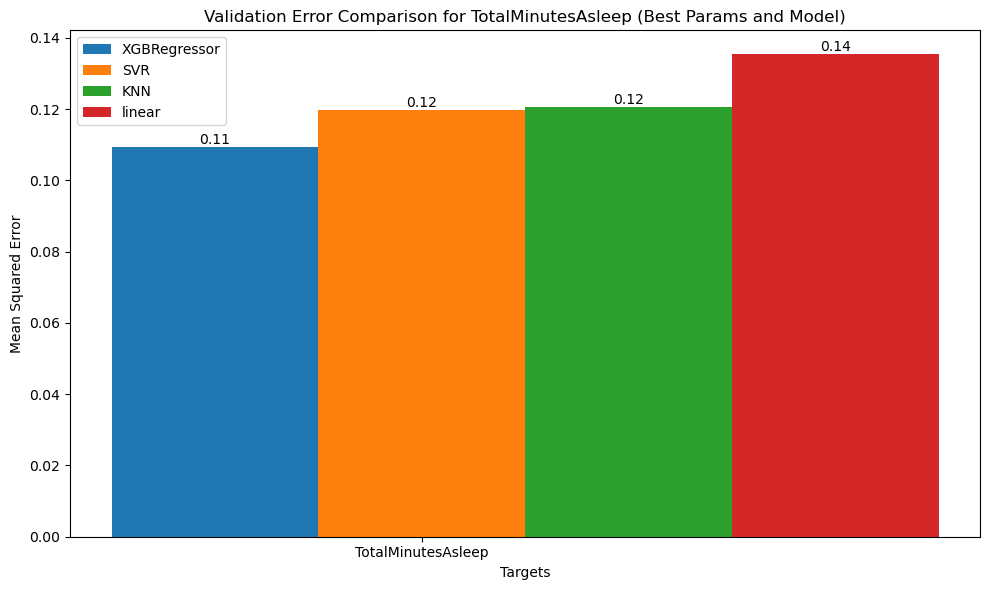

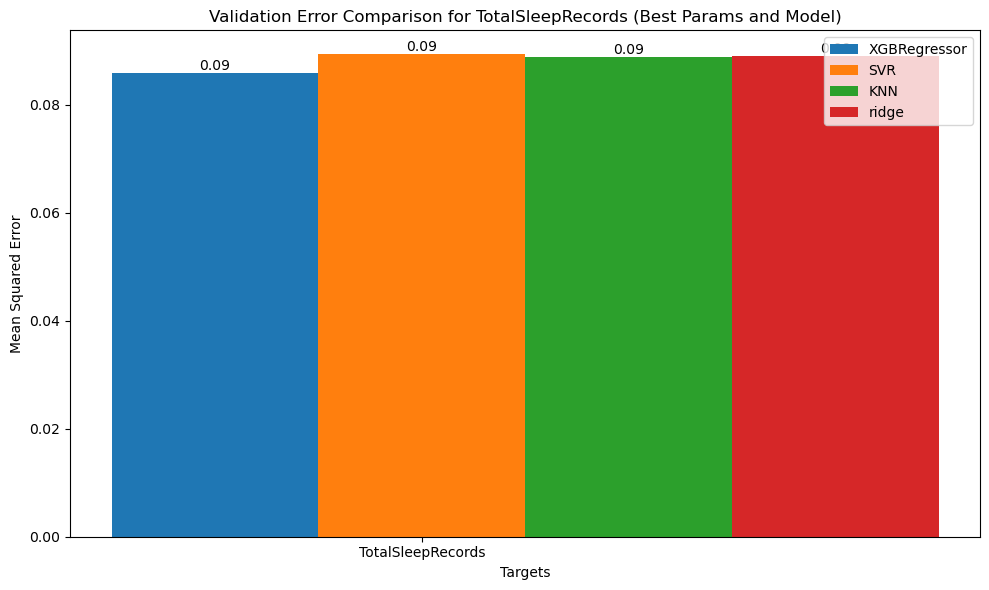

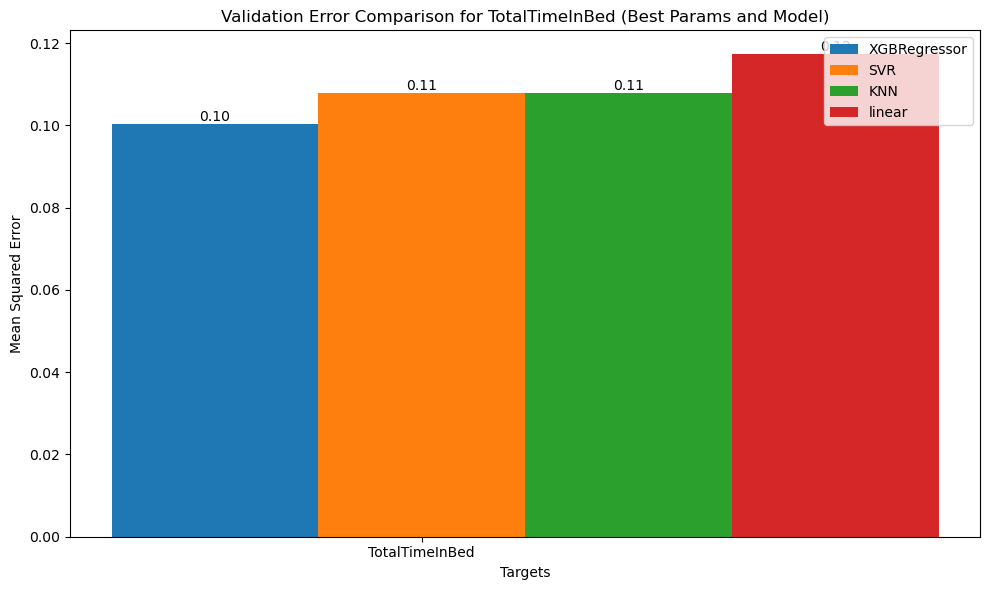

Best Model per Target Based on Lowest Validation Error:
               target         model  average_val_error  average_train_error
0  TotalMinutesAsleep  XGBRegressor           0.109451             0.019434
1   TotalSleepRecords  XGBRegressor           0.085788             0.070574
2      TotalTimeInBed  XGBRegressor           0.100373             0.016835


In [ ]:
# 1. Add a model identifier column to each best parameter DataFrame
best_params_per_target_XGB['model'] = 'XGBRegressor'
best_params_per_target_SVR['model'] = 'SVR'
best_params_per_target_KNN['model'] = 'KNN'

# 2. For Linear Regression models, only include the best (lowest average_val_error)
# Identify the best model for each target (from linear, ridge, lasso, and elastic_net) based on validation error
# First, ensure 'best_params_per_target_linear' contains the model names: linear, ridge, lasso, elastic_net

# Find the best linear model for each target (lowest average_val_error)
best_params_per_target_linear['best_linear_model'] = best_params_per_target_linear.groupby('target')['average_val_error'].transform('min')

# Filter to keep only the rows with the best model for each target (lowest validation error)
best_params_per_target_linear = best_params_per_target_linear[best_params_per_target_linear['average_val_error'] == best_params_per_target_linear['best_linear_model']]

# Now we only have the rows with the best model for each target (based on the lowest average_val_error)

# 3. Merge all results into one DataFrame (without the extra models for Linear Regression)
merged_best_params_results = pd.concat([
    best_params_per_target_XGB,
    best_params_per_target_SVR,
    best_params_per_target_KNN,
    best_params_per_target_linear[['target', 'model', 'average_val_error', 'average_train_error']]  # Include train error too
], ignore_index=True)

# 4. Identify the best model overall (across all models) for each target based on the lowest validation error
lowest_val_error_per_target = merged_best_params_results.loc[
    merged_best_params_results.groupby('target')['average_val_error'].idxmin()
].reset_index(drop=True)

# 5. Now, we can create the plot that includes all models and highlights the best performing one
def bar_graph(data, title):
    plt.figure(figsize=(10, 6))

    # Set bar width and position
    bar_width = 0.2
    x = np.arange(len(data['target'].unique()))

    # Prepare the bar positions
    for i, model in enumerate(data['model'].unique()):
        model_data = data[data['model'] == model]
        val_errors = model_data['average_val_error'].values
        bars = plt.bar(x + (i * bar_width), val_errors, width=bar_width, label=model)

        # Add value labels on top of each bar
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha='center', va='bottom')

    # Add labels and title
    plt.xlabel('Targets')
    plt.ylabel('Mean Squared Error')
    plt.title(title)
    plt.xticks(x + bar_width, data['target'].unique())  # Set x-ticks to target names
    plt.legend()
    plt.tight_layout()  # Adjust layout to prevent clipping

    plt.show()

# 6. Create bar graphs for each target with the best parameters and the best model comparison
for target in merged_best_params_results['target'].unique():
    target_data = merged_best_params_results[merged_best_params_results['target'] == target]
    bar_graph(target_data, f'Validation Error Comparison for {target} (Best Params and Model)')

# 7. Print out the best models for each target based on lowest average validation error
print("Best Model per Target Based on Lowest Validation Error:")
print(lowest_val_error_per_target[['target', 'model', 'average_val_error', 'average_train_error']])




# CALCULATING A BASELINE TO COMPARE RESULTS

In [ ]:
# Function to calculate baseline MSE for each target across all splits and seeds
def calculate_baseline_mse(splits, target_columns):
    baseline_mse_dict = {}  # Dictionary to store baseline MSE for each target

    for target_column in target_columns:
        baseline_mse_list = []  # To store baseline MSE for each split and seed

        for split in splits:
            # Unpack the split, now it includes the 'seed' value
            X_train, X_val, X_test, y_train, y_val, y_test, seed = split  # 7 items

            y_val_target = y_val[target_column]  # Extract the target column (e.g., TotalMinutesAsleep)

            # 1. Calculate the mean of the target variable in the training set
            mean_train_value = np.mean(y_train[target_column])

            # 2. Make predictions (baseline predictions will be the mean value for all instances)
            y_pred_baseline = np.full_like(y_val_target, mean_train_value)

            # 3. Calculate the MSE between the true values and the baseline predictions
            baseline_mse = mean_squared_error(y_val_target, y_pred_baseline)

            baseline_mse_list.append((seed, baseline_mse))  # Store baseline MSE with seed

        # Store the average baseline MSE for this target column
        baseline_mse_dict[target_column] = np.mean([mse for seed, mse in baseline_mse_list])

    return baseline_mse_dict

# List of target columns
target_columns = ['TotalSleepRecords', 'TotalMinutesAsleep', 'TotalTimeInBed']

# Assuming 'X' and 'y' are your feature and target datasets
# Assuming 'splits' is already generated via the split_data function

# Calculate baseline MSE for each target
baseline_mse_results = calculate_baseline_mse(splits, target_columns)

# Display results (average MSE)
for target, baseline_mse in baseline_mse_results.items():
    print(f"Baseline MSE for {target}: {baseline_mse:.4f}")


Baseline MSE for TotalSleepRecords: 0.0084
Baseline MSE for TotalMinutesAsleep: 0.0355
Baseline MSE for TotalTimeInBed: 0.0288


In [ ]:
# Define the model performance (average validation MSE from lowest_val_mse_df)
model_results = {
    'Target': ['TotalSleepRecords', 'TotalMinutesAsleep', 'TotalTimeInBed'],
    'Model': ['XGBRegressor', 'XGBRegressor', 'XGBRegressor'],
    'Average Validation Error (MSE)': [0.085788, 0.109451, 0.100373],  # From lowest_val_mse_df

}

# Create a DataFrame for model results
model_df = pd.DataFrame(model_results)

# Add the baseline MSE for each target by using the baseline_mse_results dictionary
model_df['Baseline MSE'] = [
    baseline_mse_results['TotalSleepRecords'],
    baseline_mse_results['TotalMinutesAsleep'],
    baseline_mse_results['TotalTimeInBed']
]

# Calculate the difference between model MSE and baseline MSE
model_df['MSE Difference (Model - Baseline)'] = model_df['Average Validation Error (MSE)'] - model_df['Baseline MSE']

# Print the resulting DataFrame
print(model_df)

               Target         Model  Average Validation Error (MSE)  \
0   TotalSleepRecords  XGBRegressor                        0.085788   
1  TotalMinutesAsleep  XGBRegressor                        0.109451   
2      TotalTimeInBed  XGBRegressor                        0.100373   

   Baseline MSE  MSE Difference (Model - Baseline)  
0      0.008429                           0.077359  
1      0.035505                           0.073946  
2      0.028828                           0.071545  


In [ ]:
# Define the model performance (average training MSE with provided values)
model_results = {
    'Target': ['TotalSleepRecords', 'TotalMinutesAsleep', 'TotalTimeInBed'],
    'Model': ['XGBRegressor', 'XGBRegressor', 'XGBRegressor'],
    'Average Training Error (MSE)': [0.070574, 0.019434, 0.016835],  # New values for Average Training MSE
}

# Create a new DataFrame for training results
model_df_training = pd.DataFrame(model_results)

# Add the baseline MSE for each target by using the baseline_mse_results dictionary
model_df_training['Baseline MSE'] = [
    baseline_mse_results['TotalSleepRecords'],
    baseline_mse_results['TotalMinutesAsleep'],
    baseline_mse_results['TotalTimeInBed']
]

# Calculate the difference between model training MSE and baseline MSE
model_df_training['MSE Difference (Model - Baseline)'] = model_df_training['Average Training Error (MSE)'] - model_df_training['Baseline MSE']

# Print the resulting DataFrame
print(model_df_training)

# model_df_training now contains the updated results for training error (MSE).


               Target         Model  Average Training Error (MSE)  \
0   TotalSleepRecords  XGBRegressor                      0.070574   
1  TotalMinutesAsleep  XGBRegressor                      0.019434   
2      TotalTimeInBed  XGBRegressor                      0.016835   

   Baseline MSE  MSE Difference (Model - Baseline)  
0      0.008429                           0.062145  
1      0.035505                          -0.016071  
2      0.028828                          -0.011993  


Clear signs of overfitting are evident in TotalMinutesAsleep and TotalTimeInBed, where the validation error is much higher than the training error. This indicates that the model has fit the training data very well, but it struggles to generalize to new, unseen data.
For TotalSleepRecords, while there is still a gap between training and validation error, it's smaller, suggesting less severe overfitting compared to the other two targets.

What to Do Next?
To address overfitting, you could try some of the following approaches:

Increase Data: If possible, increasing the amount of training data can help the model learn better generalizable patterns.
